In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_small
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [19]:
data_dir = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(dataset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 161MB/s]


In [23]:
train_losses = []
val_losses = []
for epoch in range(25):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')
    scheduler.step()
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_losses.append(val_loss / len(val_loader))
val_accuracy = 100 * correct / total
print(f'Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}')


Epoch 1, Loss: 0.35698258941588196
Epoch 2, Loss: 0.3628841356738754
Epoch 3, Loss: 0.352303653307583
Epoch 4, Loss: 0.3351671536979468
Epoch 5, Loss: 0.353621585537558
Epoch 6, Loss: 0.35988181570301886
Epoch 7, Loss: 0.347352631714033
Epoch 8, Loss: 0.34925187022789667
Epoch 9, Loss: 0.34261794420688046
Epoch 10, Loss: 0.3545073037562163
Epoch 11, Loss: 0.35793916297995526
Epoch 12, Loss: 0.36728295521891635
Epoch 13, Loss: 0.3418945469286131
Epoch 14, Loss: 0.33587626497382705
Epoch 15, Loss: 0.3430616774636766
Epoch 16, Loss: 0.3416636035494182
Epoch 17, Loss: 0.33905376202386356
Epoch 18, Loss: 0.3376966261345407
Epoch 19, Loss: 0.35061187135136646
Epoch 20, Loss: 0.33494552775569586
Epoch 21, Loss: 0.3591829347221748
Epoch 22, Loss: 0.35251479498718097
Epoch 23, Loss: 0.34178979565267975
Epoch 24, Loss: 0.3549496537965277
Epoch 25, Loss: 0.33952511101961136
Validation Loss: 0.3546780958771706, Validation Accuracy: 93.33333333333333


In [24]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)


[[11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0 17  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  1  0  0  0]
 [ 0  0  0

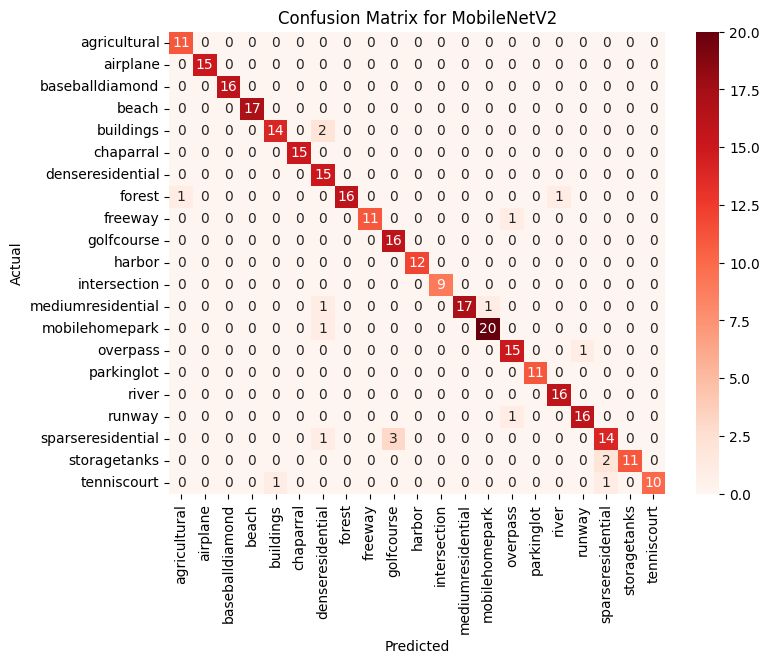

In [25]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for MobileNetV2')
plt.show()


In [26]:
report = classification_report(y_true, y_pred, target_names=dataset.classes)
print(report)

                   precision    recall  f1-score   support

     agricultural       0.92      1.00      0.96        11
         airplane       1.00      1.00      1.00        15
  baseballdiamond       1.00      1.00      1.00        16
            beach       1.00      1.00      1.00        17
        buildings       0.93      0.88      0.90        16
        chaparral       1.00      1.00      1.00        15
 denseresidential       0.75      1.00      0.86        15
           forest       1.00      0.89      0.94        18
          freeway       1.00      0.92      0.96        12
       golfcourse       0.84      1.00      0.91        16
           harbor       1.00      1.00      1.00        12
     intersection       1.00      1.00      1.00         9
mediumresidential       1.00      0.89      0.94        19
   mobilehomepark       0.95      0.95      0.95        21
         overpass       0.88      0.94      0.91        16
       parkinglot       1.00      1.00      1.00       

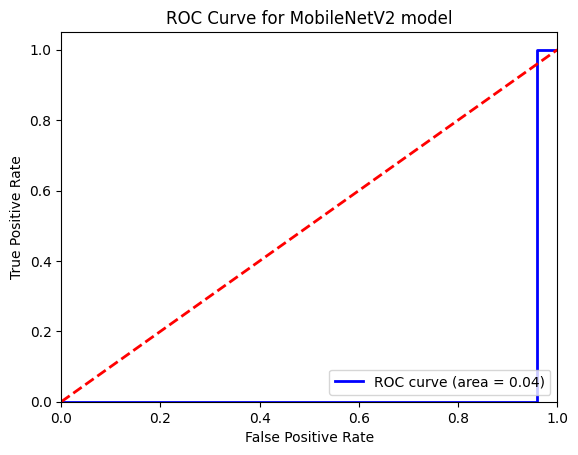

In [27]:
fpr, tpr, _ = roc_curve(y_true, np.array(y_pred), pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MobileNetV2 model')
plt.legend(loc="lower right")
plt.show()

In [28]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

kappa = cohen_kappa_score(y_true, y_pred)
oa = accuracy_score(y_true, y_pred)
print(f"MobileNetV2 Kappa Accuracy: {kappa:.4f}")
print(f"MobileNetV2 Overall Accuracy (OA): {oa:.4f}")

MobileNetV2 Kappa Accuracy: 0.9399
MobileNetV2 Overall Accuracy (OA): 0.9429


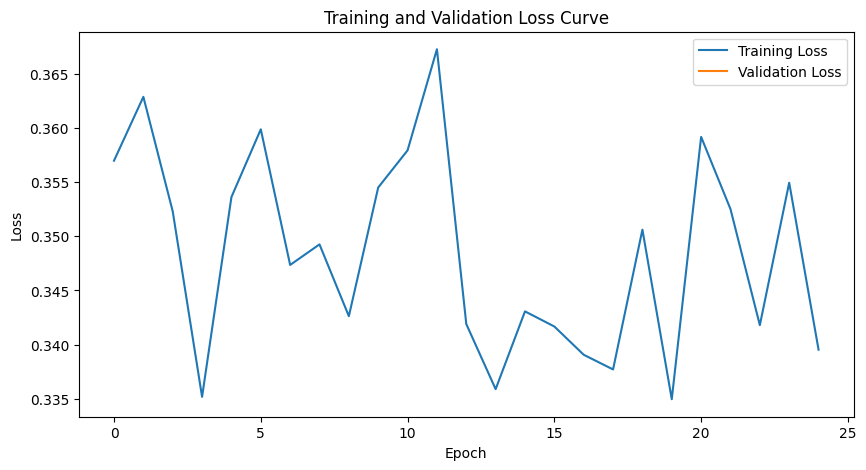

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()